# GPL Tables content

In [1]:
# Load libraries
import pandas as pd
import os
import re

In [2]:
# Read data from getGeoTest.tsv
data = pd.read_csv("../data/GPL_Supp_analisys/getGeoTest.tsv", sep='\t', usecols=["GPL_supplementary_file", "GSM_geo_accession", "GPL_geo_accession", "GPL_manufacturer","TaxId"]).drop_duplicates()

In [3]:
# Add GPL_Table Column
gpls = [f.strip('.txt') for f in os.listdir("../../GPL_Tables/")]
data["GPL_Table"] = data.GPL_geo_accession.apply(lambda f : os.path.join("../../GPL_Tables/", f"{f}.txt") if f in gpls else "None") 

In [4]:
# Convert NaN to "None"
data["GPL_supplementary_file"] = data.GPL_supplementary_file.fillna("None")

In [5]:
# Add GPL supplementary type
def gplType(row):
    if row.GPL_supplementary_file == "None":
        if row.GPL_Table == "None": return "Neither"
        return "OnlyTable" 
    if re.search(r".ndf|.cdf|.gal", row.GPL_supplementary_file): 
        if row.GPL_Table == "None":
            return "OnlyGoodSupp"
        return "GoodSuppAndTab"
    if row.GPL_Table == "None":
        return "OnlyBadSupp"
    return "BadSuppAndTab"

data["GPL_type"] = data.apply(gplType, axis=1)




In [6]:
# GSM Distribution
data.GPL_type.value_counts()

GPL_type
OnlyTable         4665
GoodSuppAndTab    2015
BadSuppAndTab      429
OnlyBadSupp          3
Name: count, dtype: int64

In [7]:
# GPL distribtution
data[["GPL_type", "GPL_geo_accession"]].drop_duplicates().GPL_type.value_counts()

GPL_type
OnlyTable         120
GoodSuppAndTab     47
BadSuppAndTab      21
OnlyBadSupp         1
Name: count, dtype: int64

In [8]:
# OnlyTable
onlyTable = [t for t in data[data.GPL_type == "OnlyTable"].GPL_Table.unique()]


In [9]:
# Find headers
def findHeaders(file):

    with open(file) as f:
        for i,line in enumerate(f.readlines()):
            if len(h := line.split('\t')) >= 2: return {col.strip() for col in h}


In [10]:
# Get headers
gplHeaders = {re.search(r"(GPL\d+)", file).group() :  findHeaders(file) for file in onlyTable}

GPL_table_header_len
7     18
6     15
8     12
9     11
5     10
13     8
4      6
16     6
14     5
10     5
11     5
3      4
19     3
17     3
2      2
15     2
12     1
33     1
23     1
18     1
21     1
Name: count, dtype: int64


<Axes: xlabel='GPL_table_header_len'>

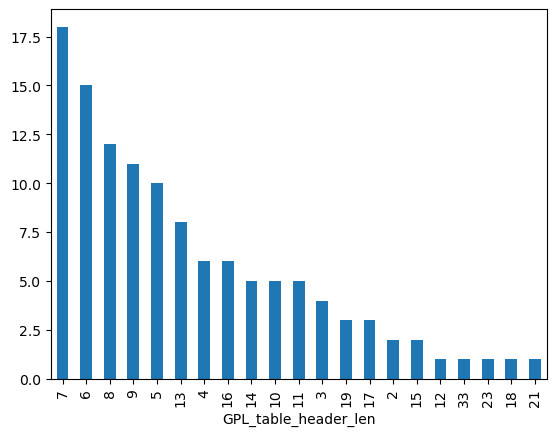

In [11]:
# Column number distribution
temp = pd.DataFrame.from_dict({"GPL_geo_accession": gplHeaders.keys(), "GPL_table_header":gplHeaders.values()})
temp["GPL_table_header_len"] = temp.GPL_table_header.apply(len)
print(temp.GPL_table_header_len.value_counts())
temp.GPL_table_header_len.value_counts().plot(kind="bar")

In [12]:
temp[temp.GPL_table_header_len == 7]

,GPL_geo_accession,GPL_table_header,GPL_table_header_len
2,GPL15025,"{ORGANISM, GENE, ORF, SEQUENCE, GENOME_ACC, ID...",7
5,GPL10901,"{SPOT_ID, Feature, ORF, SEQUENCE, ID, Probe Na...",7
15,GPL19905,"{Discription, SPOT_ID, raw, column, ORF, Block...",7
16,GPL14656,"{Spot_Id, DESCRIPTION, PRODUCT, ORF, SEQUENCE,...",7
27,GPL5482,"{LOCUS_TAG, SPOT_ID, Gene_Desc, ORF, SEQUENCE,...",7
31,GPL10041,"{synonym, probeset_id, description, ORF, pid, ...",7
34,GPL6540,"{GENE_DESCR_MFR, SPOT_ID, GENE_NAME, POS_DESCR...",7
37,GPL25141,"{SPOT_ID, ORDER, GeneName, SEQUENCE, ProbeName...",7
54,GPL8768,"{Oligo_ID, SPOT_ID, Gene_Description, Gene_Sym...",7
67,GPL8646,"{DESCRIPTION, SYMBOL, GENELOC, SEQUENCE, ID, O...",7


In [13]:
# Get all column names
allColNames = [col for header in temp.GPL_table_header for col in header]

<Axes: >

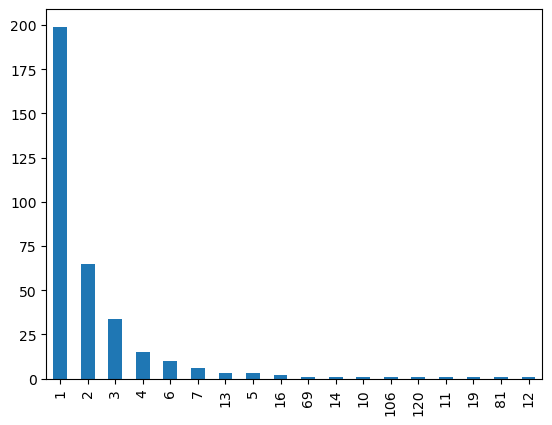

In [14]:
# Count column names appereances
# Column name repetition distribution
foo = pd.Series({col : allColNames.count(col) for col in set(allColNames)})
foo.value_counts().plot(kind="bar")

In [15]:
# Most Used Col names
foo.sort_values(ascending=False).head(n=10)

ID             120
ORF            106
SPOT_ID         81
SEQUENCE        69
Row             19
Block           16
Name            16
Gene Symbol     14
ProbeName       13
DESCRIPTION     13
dtype: int64

In [16]:
# Headers with no ORF
for i,r in temp[temp.GPL_table_header.apply(lambda cols: "ORF" not in cols)].iterrows():
    print(f"{r.GPL_geo_accession}\t{r.GPL_table_header}\t{len(r.GPL_table_header)}")

GPL343	{'GENE_SYMBOL', 'SPOT_ID', 'GB_ACC', 'SEQDERIVEDFROM', 'ID', 'SEQ_DEF'}	6
GPL22561	{'SPOT_ID', 'Cglutamicum_Locus_Tag', 'Row', 'Cglutamicum_Gene_Annotation', 'SEQUENCE', 'Name', 'Block', 'ID', 'Column'}	9
GPL16048	{'GENE_SYMBOL', 'DESCRIPTION', 'NAME', 'SPOT_ID', 'CHROMOSOMAL_LOCATION', 'GENE_NAME', 'COL', 'CONTROL_TYPE', 'GO_ID', 'SEQUENCE', 'ROW', 'ID', 'ACCESSION_STRING', 'LOCUSLINK_ID'}	14
GPL7535	{'GENE_SYMBOL', 'pO157_ORF_Name', 'GENE_DESC', 'K12_ORF_name', 'SEQUENCE', 'O157H7_Sakai_ORF_name', 'ID', 'ORF_LIST', 'O157H7_EDL933_ORF_name'}	9
GPL18392	{'NAME', 'SPOT_ID', 'CHROMOSOMAL_LOCATION', 'COL', 'CONTROL_TYPE', 'SEQUENCE', 'ROW', 'ID'}	8
GPL25141	{'SPOT_ID', 'ORDER', 'GeneName', 'SEQUENCE', 'ProbeName', 'ID', 'ORF_LIST'}	7
GPL1343	{'DESCRIPTION', 'CLONE_ID.1', 'SPOT_ID', 'MADB_WELL_ID', 'GENE', 'OLIGO_ID', 'SEQUENCE', 'CLONE_ID', 'ID'}	9
GPL10455	{'MT gene', 'SPOT_ID', 'Rv gene', 'gene description', 'spot', 'ID', 'ORF_LIST', 'gene symbol'}	8
GPL18296	{'SPOT_ID', 'Control

In [17]:
xd = data[data.GPL_geo_accession.isin(temp[temp.GPL_table_header.apply(lambda cols: "ORF" not in cols)].GPL_geo_accession)]

In [18]:
xd[xd.GPL_geo_accession == "GPL7137"]

,TaxId,GPL_geo_accession,GPL_manufacturer,GPL_supplementary_file,GSM_geo_accession,GPL_Table,GPL_type
6874,158878,GPL7137,Agilent,None,GSM1589603,../../GPL_Tables/GPL7137.txt,OnlyTable
6875,158878,GPL7137,Agilent,None,GSM1589604,../../GPL_Tables/GPL7137.txt,OnlyTable
6876,158878,GPL7137,Agilent,None,GSM1589605,../../GPL_Tables/GPL7137.txt,OnlyTable
6877,158878,GPL7137,Agilent,None,GSM1589606,../../GPL_Tables/GPL7137.txt,OnlyTable
6878,158878,GPL7137,Agilent,None,GSM1589607,../../GPL_Tables/GPL7137.txt,OnlyTable
...,...,...,...,...,...,...,...
6933,158878,GPL7137,Agilent,None,GSM569074,../../GPL_Tables/GPL7137.txt,OnlyTable
6934,158878,GPL7137,Agilent,None,GSM376041,../../GPL_Tables/GPL7137.txt,OnlyTable
6935,158878,GPL7137,Agilent,None,GSM376042,../../GPL_Tables/GPL7137.txt,OnlyTable
6936,158878,GPL7137,Agilent,None,GSM376043,../../GPL_Tables/GPL7137.txt,OnlyTable


In [19]:
data[data.TaxId == 158878]

,TaxId,GPL_geo_accession,GPL_manufacturer,GPL_supplementary_file,GSM_geo_accession,GPL_Table,GPL_type
4029,158878,GPL22334,NimbleGen,geo/platforms/GPL22nnn/GPL22334/suppl/GPL22334...,GSM2285079,../../GPL_Tables/GPL22334.txt,GoodSuppAndTab
4030,158878,GPL22334,NimbleGen,geo/platforms/GPL22nnn/GPL22334/suppl/GPL22334...,GSM2285080,../../GPL_Tables/GPL22334.txt,GoodSuppAndTab
4031,158878,GPL22334,NimbleGen,geo/platforms/GPL22nnn/GPL22334/suppl/GPL22334...,GSM2285081,../../GPL_Tables/GPL22334.txt,GoodSuppAndTab
4032,158878,GPL22334,NimbleGen,geo/platforms/GPL22nnn/GPL22334/suppl/GPL22334...,GSM2285082,../../GPL_Tables/GPL22334.txt,GoodSuppAndTab
4033,158878,GPL22334,NimbleGen,geo/platforms/GPL22nnn/GPL22334/suppl/GPL22334...,GSM2285083,../../GPL_Tables/GPL22334.txt,GoodSuppAndTab
...,...,...,...,...,...,...,...
6933,158878,GPL7137,Agilent,None,GSM569074,../../GPL_Tables/GPL7137.txt,OnlyTable
6934,158878,GPL7137,Agilent,None,GSM376041,../../GPL_Tables/GPL7137.txt,OnlyTable
6935,158878,GPL7137,Agilent,None,GSM376042,../../GPL_Tables/GPL7137.txt,OnlyTable
6936,158878,GPL7137,Agilent,None,GSM376043,../../GPL_Tables/GPL7137.txt,OnlyTable


In [20]:
tx = pd.read_csv("./taxonomyRelation_getGeoTest.tsv", sep='\t')

In [21]:
a = data.merge(tx)
a[a.Specie == "Staphylococcus aureus"].TaxId

3916    426430
3917    426430
3918    426430
3919    426430
3920    426430
         ...  
6920    158878
6921    158878
6922     93062
6923     93062
6924     93062
Name: TaxId, Length: 360, dtype: int64